In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from functions.load_data import load_data
from functions.run_model import run_model


In [4]:
#your_data_df = load_data("data/your_synthetic_data.csv")
#comparison_data_df = load_data("data/comparison_synthetic_data.csv")
tabs = load_data("data/comparison_synthetic_data.csv", globals())
oppida = load_data("data/your_synthetic_data.csv", globals())


In [15]:
print(tabs)

['Deposit_1' 'Deposit_2' 'Deposit_3' 'Deposit_4' 'Deposit_5']


In [5]:
import numpy as np
from scipy.stats import gaussian_kde

def calculate_overlap_percentage(data1, data2, bw="silverman"):
    data1 = data1.dropna()
    data2 = data2.dropna()
    
    kde1 = gaussian_kde(data1, bw_method=bw)
    kde2 = gaussian_kde(data2, bw_method=bw)

    common_grid = np.linspace(
        min(min(data1), min(data2)), max(max(data1), max(data2)), 1000)

    density1_interp = kde1.evaluate(common_grid)
    density2_interp = kde2.evaluate(common_grid)
    
    overlap_area = np.trapz(np.minimum(density1_interp, density2_interp), common_grid)
    
    total_area1 = np.trapz(density1_interp, common_grid)
    total_area2 = np.trapz(density2_interp, common_grid)
    
    overlap_percentage = (2 * overlap_area) / (total_area1 + total_area2) * 100
    
    return overlap_percentage

In [6]:
def calculate_percentage_comparison(your_data, tabs, isotope_column):
    results = []
    for sheet in tabs:
        df_name = f"df_{sheet}" 
        df = globals()[df_name]
        
        your_data_clean = pd.to_numeric(your_data[isotope_column], errors='coerce').dropna()
        df_clean = pd.to_numeric(df[isotope_column], errors='coerce').dropna()
        
        # Calculate the overlap percentage
        overlap_percentage = calculate_overlap_percentage(your_data_clean, df_clean)
        results.append((sheet, overlap_percentage))
    
    return results

In [16]:
def get_comparison_results(isotope_ratios):
    comparison_data = {isotope: calculate_percentage_comparison(df_MyData, tabs, isotope) for isotope in isotope_ratios}
    return comparison_data

In [17]:
isotope_ratios = ["208Pb/204Pb", "207Pb/204Pb", "206Pb/204Pb"]

comparison_results = get_comparison_results(isotope_ratios)
comparison_results

{'208Pb/204Pb': [('Deposit_1', 94.1408940779478),
  ('Deposit_2', 90.58116422015422),
  ('Deposit_3', 95.43958291412079),
  ('Deposit_4', 97.10274858121193),
  ('Deposit_5', 95.10685054132674)],
 '207Pb/204Pb': [('Deposit_1', 94.89468513098349),
  ('Deposit_2', 94.47024052986957),
  ('Deposit_3', 95.0027844971267),
  ('Deposit_4', 95.78486579783475),
  ('Deposit_5', 97.04470640743938)],
 '206Pb/204Pb': [('Deposit_1', 96.61864443337151),
  ('Deposit_2', 89.71059203980045),
  ('Deposit_3', 93.5816900646417),
  ('Deposit_4', 98.72816352994464),
  ('Deposit_5', 92.50866998800791)]}

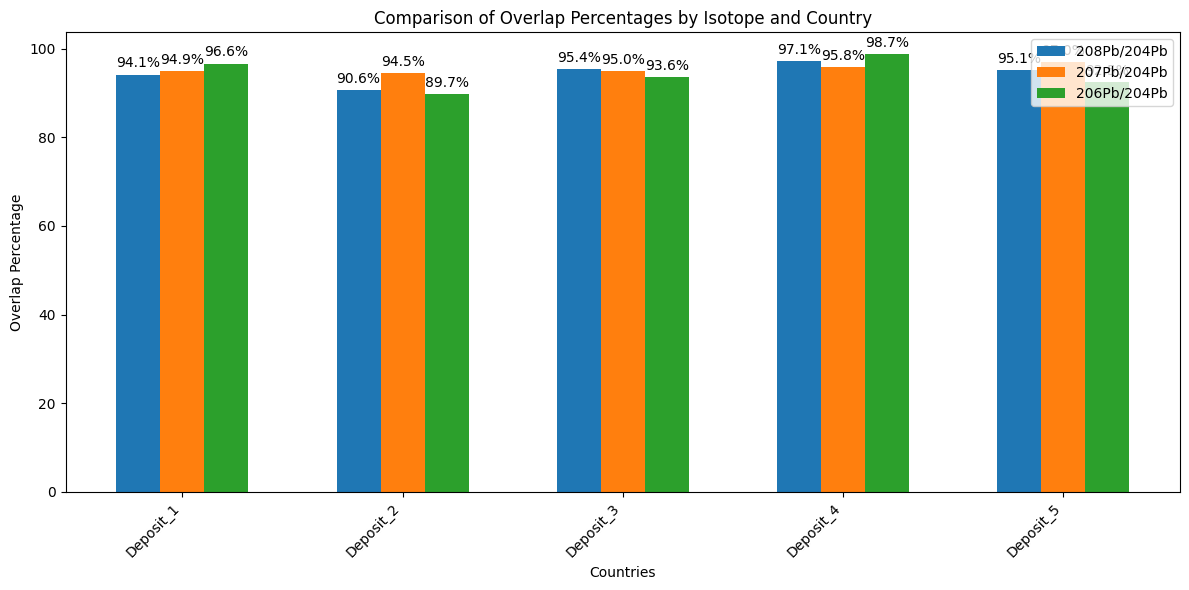

In [18]:
countries = [result[0] for result in comparison_results[isotope_ratios[0]]] 
values_by_isotope = {isotope: [result[1] for result in comparison_results[isotope]] for isotope in isotope_ratios}

x = np.arange(len(countries)) 
width = 0.2 

fig, ax = plt.subplots(figsize=(12, 6))

for i, isotope in enumerate(isotope_ratios):
    bars = ax.bar(x + i * width, values_by_isotope[isotope], width, label=isotope)
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

ax.set_xlabel('Countries')
ax.set_ylabel('Overlap Percentage')
ax.set_title('Comparison of Overlap Percentages by Isotope and Country')
ax.set_xticks(x + width)
ax.set_xticklabels(countries, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [19]:
country_ratios = {}

# Extract and organize data
for ratio, entries in comparison_results.items():
    for country, value in entries:
        if country not in country_ratios:
            country_ratios[country] = [None, None, None]
        
        # Determine index for the ratio
        if ratio == '208Pb/204Pb':
            country_ratios[country][0] = value
        elif ratio == '207Pb/204Pb':
            country_ratios[country][1] = value
        elif ratio == '206Pb/204Pb':
            country_ratios[country][2] = value

# Print the arrays for each country
for country, ratios in country_ratios.items():  
        mean = np.mean(ratios)
        
        print(f"{country}: {mean:.2f}%")

Deposit_1: 95.22%
Deposit_2: 91.59%
Deposit_3: 94.67%
Deposit_4: 97.21%
Deposit_5: 94.89%


C:\Users\dakis\AppData\Local\Temp\ipykernel_19020\305235250.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(probabilities.keys(), rotation=45, ha='right')


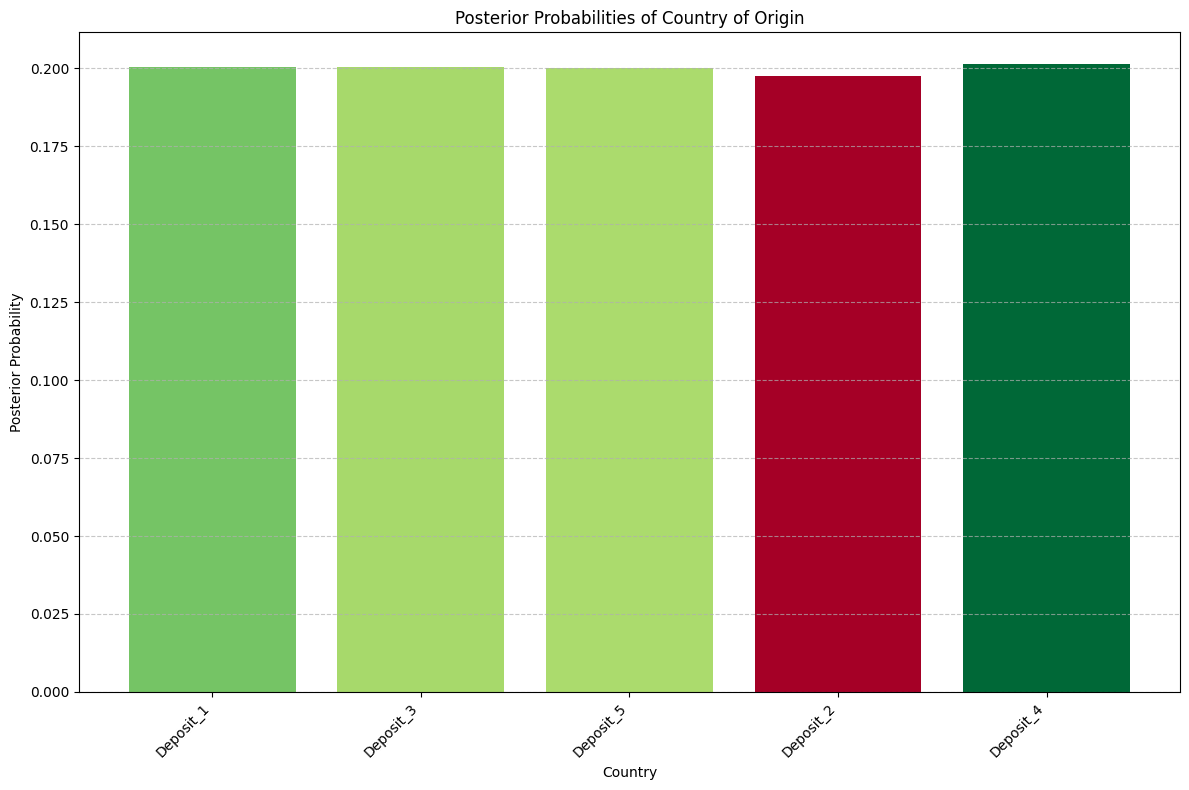

In [20]:
def extract_ratios(data):
    countries = set([country for ratio_list in data.values() for country, _ in ratio_list])
    country_ratios = {country: [] for country in countries}

    for ratio_type, ratio_list in data.items():
        for country, ratio in ratio_list:
            country_ratios[country].append(ratio / 100) 
    
    return country_ratios

def calculate_likelihood(match_ratios):
    return np.exp(-np.sum((1 - np.array(match_ratios))**2))

def calculate_probabilities(data):
    country_ratios = extract_ratios(data)
    
    likelihoods = {country: calculate_likelihood(ratios) for country, ratios in country_ratios.items()}

    total_likelihood = sum(likelihoods.values())
    probabilities = {country: likelihood / total_likelihood for country, likelihood in likelihoods.items()}
    
    return probabilities

probabilities = calculate_probabilities(comparison_results)

cmap = plt.get_cmap('RdYlGn')

norm = plt.Normalize(vmin=min(probabilities.values()), vmax=max(probabilities.values()))

fig, ax = plt.subplots(figsize=(12, 8))

colors = [cmap(norm(value)) for value in probabilities.values()]
bars = ax.bar(probabilities.keys(), probabilities.values(), color=colors)

ax.set_xlabel("Country")
ax.set_ylabel("Posterior Probability")
ax.set_title("Posterior Probabilities of Country of Origin")

ax.set_xticklabels(probabilities.keys(), rotation=45, ha='right')

ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
